# PyMVPA

[PyMVPA](http://www.pymvpa.org/) is a Python package intended to ease statistical learning analyses of large datasets. It offers an extensible framework with a high-level interface to a broad range of algorithms for classification, regression, feature selection, data import and export.

It is designed to integrate well with related software packages, such as [scikit-learn](http://scikit-learn.org/stable/), [shogun](http://www.shogun-toolbox.org/), [MDP](http://mdp-toolkit.sourceforge.net/), etc. While it is not limited to the neuroimaging domain, it is eminently suited for such datasets. PyMVPA is free software and requires nothing but free-software to run.

The power in PyMVPA lies in it's flexibility with classifier. PyMVPA is able to use many classifiers from LIBSVM and scikit-learn, and the overall list that are at your hands is impressive. The following are only some of the classifiers that you can chose from:

- Bayesian Linear Regression (BLR)
- Elastic-Net (ENET) regression classifier
- Gaussian Discriminant Analyses (LDA and QDA)
- Gaussian Naive Bayes Classifier (GNB)
- Gaussian Process Regression (GPR)
- GLM-Net (GLMNET) regression and classifier
- k-Nearest-Neighbour classifier (kNN)
- Least angle regression (LARS)
- Penalized logistic regression classifier
- Similarity functions for prototype-based projection
- Sparse Multinomial Logistic Regression classifier (SMLR)
- SVM and SVR machines

**Note:** The content of this notebook is taken and adapted from the [PyMVPA](http://www.pymvpa.org/) homepage and serves an illustrative purpose. For more information and better understanding, go directly to [PyMVPA](http://www.pymvpa.org/).

Having said so, let's take a look at a few examples.

## Tutorial Dataset

To do anything in this tutoroial, we first need to download some tutorial data. This can be done with the following command:

In [ ]:
%%bash
curl http://data.pymvpa.org/datasets/tutorial_data/tutorial_data-0.4.tar.gz | tar xvz \
    -C /home/neuro/workshop
mv /home/neuro/workshop/tutorial_data/data /home/neuro/workshop/tutorial_data/haxby2001

## Searchlight on fMRI data

The original idea of a spatial searchlight algorithm stems from a paper by [Kriegeskorte et al. (2006)](http://www.pymvpa.org/references.html#kgb06), and has subsequently been used in a number of studies. The most common use for a searchlight is to compute a full cross-validation analysis in each spherical region of interest (ROI) in the brain. This analysis yields a map of (typically) classification accuracies that are often interpreted or post-processed similar to a GLM statistics output map (e.g. subsequent analysis with inferential statistics).

### Preparation

In [ ]:
# Import relevant modules
from mvpa2.suite import *
import os
%matplotlib inline

As searchlight analyses are usually quite expensive in terms of computational resources, we are going to enable some progress output to entertain us while we are waiting.

In [ ]:
# enable debug output for searchlight call
if __debug__:
    debug.active += ["SLC"]

### Get data

The next few calls load an fMRI dataset, while assigning associated class targets and chunks (experiment runs) to each volume in the 4D timeseries. One aspect is worth mentioning. When loading the fMRI data with [fmri_dataset()](http://www.pymvpa.org/generated/mvpa2.datasets.mri.fmri_dataset.html#mvpa2.datasets.mri.fmri_dataset) additional feature attributes can be added, by providing a dictionary with names and source pairs to the **add_fa** arguments. In this case we are loading a thresholded zstat-map of a category selectivity contrast for voxels ventral temporal cortex.

In [ ]:
datapath = '/home/neuro/workshop/tutorial_data'
dataset = load_tutorial_data(path=datapath,
        roi='brain',
        add_fa={'vt_thr_glm': os.path.join(datapath, 'haxby2001', 'sub001', 'masks',
                                                     'orig', 'vt.nii.gz')})

### Prepare data

The dataset is now loaded and contains all brain voxels as features, and all volumes as samples. To precondition this data for the intended analysis we have to perform a few preprocessing steps (please note that the data was already motion-corrected). The first step is a chunk-wise (run-wise) removal of linear trends, typically caused by the acquisition equipment.

In [ ]:
poly_detrend(dataset, polyord=1, chunks_attr='chunks')

Now that the detrending is done, we can remove parts of the timeseries we are not interested in. For this example we are only considering volumes acquired during a stimulation block with images of houses and scrambled pictures, as well as rest periods (for now). It is important to perform the detrending before this selection, as otherwise the equal spacing of fMRI volumes is no longer guaranteed.

In [ ]:
dataset = dataset[np.array([l in ['rest', 'house', 'scrambledpix']
                           for l in dataset.targets], dtype='bool')]

The final preprocessing step is data-normalization. This is a required step for many classification algorithms. It scales all features (voxels) into approximately the same range and removes the mean. In this example, we perform a chunk-wise normalization and compute standard deviation and mean for z-scoring based on the volumes corresponding to rest periods in the experiment. The resulting features could be interpreted as being voxel salience relative to ‘rest’.

In [ ]:
zscore(dataset, chunks_attr='chunks', param_est=('targets', ['rest']), dtype='float32')


After normalization is completed, we no longer need the ‘rest’-samples and remove them.

In [ ]:
dataset = dataset[dataset.sa.targets != 'rest']

### Specify Classifier

But now for the interesting part: Next we define the measure that shall be computed for each sphere. Theoretically, this can be anything, but here we choose to compute a full leave-one-out cross-validation using a linear Nu-SVM classifier.

In [ ]:
# choose classifier
clf = LinearNuSVMC()

# setup measure to be computed by Searchlight
# cross-validated mean transfer using an N-fold dataset splitter
cv = CrossValidation(clf, NFoldPartitioner())

In this example, we do not want to compute full-brain accuracy maps, but instead limit ourselves to a specific subset of voxels. We’ll select all voxel that have a non-zero z-stats value in the localizer mask we loaded above, as center coordinates for a searchlight sphere. These spheres will still include voxels that did not pass the threshold. the localizer merely define the location of all to be processed spheres.

In [ ]:
# get ids of features that have a nonzero value
center_ids = dataset.fa.vt_thr_glm.nonzero()[0]

Finally, we can run the searchlight. We’ll perform the analysis for three different radii, each time computing an error for each sphere. To achieve this, we simply use the [sphere_searchlight()](http://www.pymvpa.org/generated/mvpa2.measures.searchlight.sphere_searchlight.html#mvpa2.measures.searchlight.sphere_searchlight) class, which takes any [processing object](http://www.pymvpa.org/glossary.html#term-processing-object) and a radius as arguments. The [processing object](http://www.pymvpa.org/glossary.html#term-processing-object) has to compute the intended measure, when called with a dataset. The [sphere_searchlight()](http://www.pymvpa.org/generated/mvpa2.measures.searchlight.sphere_searchlight.html#mvpa2.measures.searchlight.sphere_searchlight) object will do nothing more than generate small datasets for each sphere, feeding them to the processing object, and storing the result.

In [ ]:
# setup plotting parameters (not essential for the analysis itself)
plot_args = {
    'background' : os.path.join(datapath, 'haxby2001', 'sub001', 'anatomy', 'highres001.nii.gz'),
    'background_mask' : os.path.join(datapath, 'haxby2001', 'sub001', 'masks', 'orig', 'brain.nii.gz'),
    'overlay_mask' : os.path.join(datapath, 'haxby2001', 'sub001', 'masks', 'orig', 'vt.nii.gz'),
    'do_stretch_colors' : False,
    'cmap_bg' : 'gray',
    'cmap_overlay' : 'autumn', # YlOrRd_r # pl.cm.autumn
    'interactive' : cfg.getboolean('examples', 'interactive', True),
    }

### Run Searchlight

In [ ]:
# Chose Sphere radius
radius = 0

# tell which one we are doing
print("Running searchlight with radius: %i ..." % (radius))

Running searchlight with radius: 0 ...


Here we actually setup the spherical searchlight by configuring the radius, and our selection of sphere center coordinates. Moreover, via the **space** argument we can instruct the searchlight which feature attribute shall be used to determine the voxel neighborhood. By default, fmri_dataset() creates a corresponding attribute called **voxel_indices**. Using the **mapper** argument it is possible to post-process the results computed for each sphere. Cross-validation will compute an error value per each fold, but here we are only interested in the mean error across all folds. Finally, on multi-core machines **nproc** can be used to enabled parallelization by setting it to the number of processes utilized by the searchlight (default value of **nproc`=`None** utilizes all available local cores).

In [ ]:
sl = sphere_searchlight(cv, radius=radius, space='voxel_indices',
                        center_ids=center_ids,
                        postproc=mean_sample())

Since we care about efficiency, we are stripping all attributes from the dataset that are not required for the searchlight analysis. This will offers some speedup, since it reduces the time that is spent on dataset slicing.

In [ ]:
ds = dataset.copy(deep=False,
                  sa=['targets', 'chunks'],
                  fa=['voxel_indices'],
                  a=['mapper'])

Finally, we actually run the analysis. The result is returned as a dataset. For the upcoming plots, we are transforming the returned error maps into accuracies.

In [ ]:
# Runs the serachlight
sl_map = sl(ds)

# Changes output from error maps to accuracy maps
sl_map.samples *= -1
sl_map.samples += 1

[SLC] DBG:                         Starting off 8 child processes for nblocks=8
[SLC] DBG:                               Starting computing block for 73 elements
[SLC] DBG:                               Starting computing block for 72 elements
[SLC] DBG:                               Starting computing block for 72 elements
[SLC] DBG:                               Starting computing block for 72 elements
[SLC] DBG:                               Starting computing block for 72 elements
[SLC] DBG:                               Starting computing block for 72 elements
[SLC] DBG:                               Starting computing block for 72 elements
[SLC] DBG:                               Starting computing block for 72 elements
[SLC] DBG:                               +0:00:15 ======[100%]====== 0:00:00  ROI 12209 (72/72), 1 features 
[SLC] DBG:                               +0:00:15 ======[100%]====== 0:00:00  ROI 37354 (72/72), 1 features 
[SLC] DBG:                               +0:00

### Investigat the results

The result dataset is fully aware of the original dataspace. Using this information we can map the 1D accuracy maps back into “brain-space” (using NIfTI image header information from the original input timeseries.

In [ ]:
niftiresults = map2nifti(sl_map, imghdr=dataset.a.imghdr)

PyMVPA comes with a convenient plotting function to visualize the searchlight maps. We are only looking at fMRI slices that are covered by the mask of ventral temproal cortex.

The following figures show the resulting accuracy maps for the slices covered by the ventral temporal cortex mask. Note that each voxel value represents the accuracy of a sphere centered around this voxel.

Searchlight (single element; univariate) accuracy maps for binary classification house vs. scrambledpix.


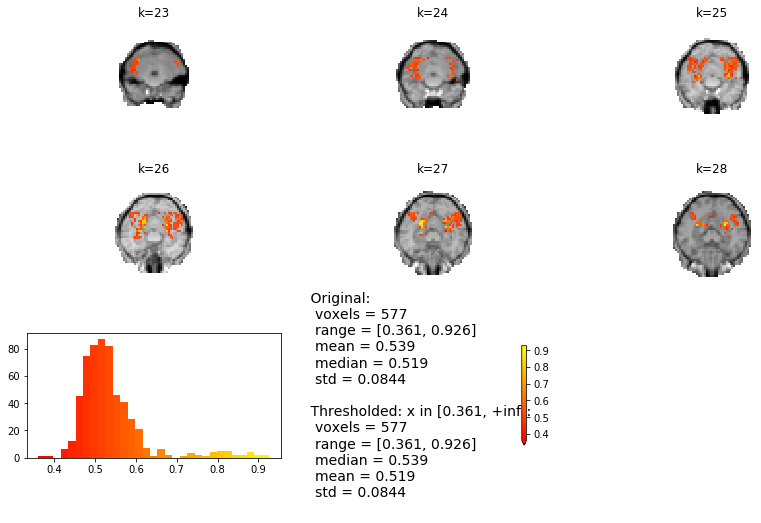

In [ ]:
print('Searchlight (single element; univariate) accuracy maps '
      'for binary classification house vs. scrambledpix.')
fig = pl.figure(figsize=(12, 8), facecolor='white')
subfig = plot_lightbox(overlay=niftiresults,
                       vlim=(0.0, None), slices=range(23,29),
                       fig=fig, **plot_args);

With radius 0 (only the center voxel is part of the part the sphere) there is a clear distinction between two distributions. The chance distribution, relatively symetric and centered around the expected chance-performance at 50%. The second distribution, presumambly of voxels with univariate signal, is nicely segregated from that. 

### Run searchlight again, but this time with a sphere radius of 3

Increasing the searchlight size significantly blurrs the accuracy map, but also lead to an increase in classification accuracy. So let's try the searchlight again with a sphere radius of 3.

In [ ]:
radius = 3
sl = sphere_searchlight(cv, radius=radius, space='voxel_indices',
                        center_ids=center_ids, postproc=mean_sample())
sl_map = sl(ds)
sl_map.samples *= -1
sl_map.samples += 1
niftiresults = map2nifti(sl_map, imghdr=dataset.a.imghdr)

[SLC] DBG:                         Starting off 8 child processes for nblocks=8
[SLC] DBG:                               Starting computing block for 73 elements
[SLC] DBG:                               Starting computing block for 72 elements
[SLC] DBG:                               Starting computing block for 72 elements
[SLC] DBG:                               Starting computing block for 72 elements
[SLC] DBG:                               Starting computing block for 72 elements
[SLC] DBG:                               Starting computing block for 72 elements
[SLC] DBG:                               Starting computing block for 72 elements
[SLC] DBG:                               Starting computing block for 72 elements
[SLC] DBG:                               +0:00:24 ======[97%]======_ -0:00:00  ROI 34465 (70/72), 123 features
[SLC] DBG:                               +0:00:24 ======[100%]====== 0:00:00  ROI 29879 (72/72), 123 features 
[SLC] DBG:                               +

Searchlight (radius 3 elements; 123 voxels) accuracy maps for binary classification house vs. scrambledpix.


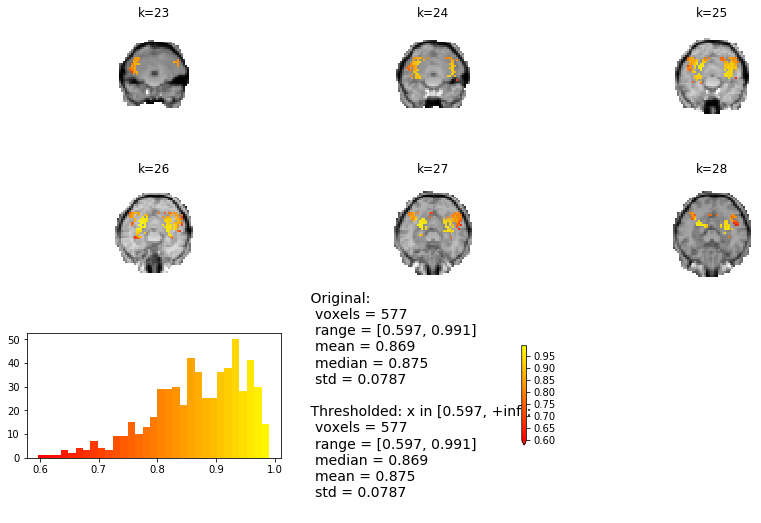

In [ ]:
print('Searchlight (radius 3 elements; 123 voxels) accuracy maps for '
      'binary classification house vs. scrambledpix.')
fig = pl.figure(figsize=(12, 8), facecolor='white')
subfig = plot_lightbox(
    overlay=niftiresults, vlim=(0.0, None),
    slices=range(23,29), fig=fig, **plot_args)

## Multi-dimensional Searchlights

This is a little addendum to the previous example that gives us a little glimpse on the power of PyMVPA for "multi-space" analysis.

First let’s create a dataset with the spatio-temporal features from [Event-related Data Analysis](http://www.pymvpa.org/tutorial_eventrelated.html#chap-tutorial-eventrelated):

In [ ]:
from mvpa2.tutorial_suite import *

# Create dataset
ds = get_raw_haxby2001_data(path='/home/neuro/workshop/tutorial_data/', roi=(36,38,39,40))

# Perform linear detrending
poly_detrend(ds, polyord=1, chunks_attr='chunks')

# Normalize the dataset
zscore(ds, chunks_attr='chunks', param_est=('targets', 'rest'))

# Specify Events
events = find_events(targets=ds.sa.targets, chunks=ds.sa.chunks)
events = [ev for ev in events if ev['targets'] in ['house', 'face']]

# Specify temporal information
event_duration = 13
for ev in events:
    ev['onset'] -= 2
    ev['duration'] = event_duration
    
# Update dataset
evds = eventrelated_dataset(ds, events=events)

From the example above we know hot to do searchlight analyses. But PyMVPA can of course do more than just a simple spatial searchlight analysis.

Let's look at the following code:

In [ ]:
cvte = CrossValidation(GNB(), NFoldPartitioner(),
                       postproc=mean_sample())
sl = Searchlight(cvte,
                 IndexQueryEngine(voxel_indices=Sphere(1),
                                  event_offsetidx=Sphere(2)),
                 postproc=mean_sample())

Have you been able to deduce what this analysis will do? Clearly, it is some sort of searchlight, but it doesn't use [`sphere_searchlight()`](http://www.pymvpa.org/generated/mvpa2.measures.searchlight.sphere_searchlight.html#mvpa2.measures.searchlight.sphere_searchlight). Instead, it utilizes [`Searchlight`](http://www.pymvpa.org/generated/mvpa2.measures.searchlight.Searchlight.html#mvpa2.measures.searchlight.Searchlight). Yes, you are correct this is a spatio-temporal searchlight. The searchlight focus travels along all possible locations in our ventral temporal ROI, but at the same time also along the peristimulus time segment covered by the events. The spatial searchlight extent is the center voxel and its immediate neighbors and the temporal dimension comprises of two additional time-points in each direction. The result is again a dataset. Its shape is compatible with the mapper of evds, hence it can also be back-projected into the original 4D fMRI brain space.

In [ ]:
# So let's run this spatio-temporal searchlight
res = sl(evds)

[SLC] DBG:                         Starting off 8 child processes for nblocks=8
[SLC] DBG:                               Starting computing block for 1530 elements
[SLC] DBG:                               Starting computing block for 1529 elements
[SLC] DBG:                               Starting computing block for 1529 elements
[SLC] DBG:                               Starting computing block for 1529 elements
[SLC] DBG:                               Starting computing block for 1529 elements
[SLC] DBG:                               Starting computing block for 1529 elements
[SLC] DBG:                               Starting computing block for 1529 elements
[SLC] DBG:                               Starting computing block for 1529 elements
[SLC] DBG:                               +0:06:17 ======[100%]====== 0:00:00  ROI 1530 (1530/1530), 20 features s
[SLC] DBG:                               +0:06:18 ======[100%]====== 0:00:00  ROI 4588 (1529/1529), 25 features  
[SLC] DBG:          

[`Searchlight`](http://www.pymvpa.org/generated/mvpa2.measures.searchlight.Searchlight.html#mvpa2.measures.searchlight.Searchlight) is a powerful class that allows for complex runtime ROI generation. In this case it uses an [`IndexQueryEngine`](http://www.pymvpa.org/generated/mvpa2.misc.neighborhood.IndexQueryEngine.html#mvpa2.misc.neighborhood.IndexQueryEngine) to look at certain feature attributes in the dataset to compose sphere-shaped ROIs in two spaces at the same time. This approach is very flexible and can be extended with additional query engines to algorithms of almost arbitrary complexity.

So let's take now the output of this 4D searchlight and put it back into a NIfTI file.

In [ ]:
ts = res.a.mapper.reverse1(1 - res.samples[0])

# need to put the time axis last for export to NIfTI
ts = np.rollaxis(ts, 0, 4)
ni = nb.Nifti1Image(ts, ds.a.imgaffine).to_filename('ersl.nii')

## Curve-Fitting

This is just a short example to show that you can also use PyMVPA to fit a function to your data. In this specific case, fitting an HRF model to noisy peristimulus time-series data.

First, importing the necessary pieces:

In [ ]:
%matplotlib inline
import numpy as np

from mvpa2.support.pylab import pl
from mvpa2.misc.plot import plot_err_line
from mvpa2.misc.fx import *

### BOLD-Response parameters

Let's generate some noisy "trial time courses" from a simple gamma function (40 samples, 6s time-to-peak, 7s FWHM and no additional scaling:

In [ ]:
a = np.asarray([single_gamma_hrf(np.arange(20), A=6, W=7, K=1)] * 40)
# get closer to reality with noise
a += np.random.normal(size=a.shape)

Fitting a gamma function to this data is easy (using resonable seeds for the parameter search (5s time-to-peak, 5s FWHM, and no scaling):

In [ ]:
fpar, succ = least_sq_fit(single_gamma_hrf, [5,5,1], a)

With these parameters we can compute high-resultion curves for the estimated time course, and plot it together with the "true" time course, and the data:

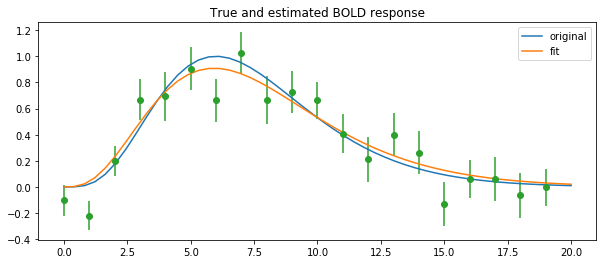

In [ ]:
x = np.linspace(0,20)
curves = [(x, single_gamma_hrf(x, 6, 7, 1)),
          (x, single_gamma_hrf(x, *fpar))]

# plot data (with error bars) and both curves
fig = pl.figure(figsize=(10, 4))
plot_err_line(a, curves=curves, linestyle='-')

# add legend to plot
pl.legend(('original', 'fit'))
pl.title('True and estimated BOLD response');